# EDA for Reddit- Wallstreebeets comments 2018-2019

references https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import json
import vaex
import re
import itertools
import collections
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer


### input data processing

The data was downloaded from the internet from  http://files.pushshift.io/reddit/comments/

The files are compressed in Zstandard format. A script was used to convert ehe files from Zst to JSON or CSV depending in the particular file. This was done outside of this jupyter notebook

In [4]:
# ##### Import data from CSV with 
# df_2018_2019 = vaex.from_csv('D:/reddit_data/df_2018-2019.csv', convert=True, chunk_size=5_000_000, low_memory=False)
# df_2018_2019 = df_2018_2019.to_pandas_df()
# df_2020 = vaex.from_csv('D:/reddit_data/df_2020.csv', convert=True, chunk_size=5_000_000, low_memory=False)
# df_2020 = df_2020.to_pandas_df()
# df_2021 = vaex.from_csv('D:/reddit_data/df_2021.csv', convert=True, chunk_size=5_000_000, low_memory=False)
# df_2021 = df_2021.to_pandas_df()

# frames = [df_2018_2019, df_2020, df_2021]
# df = pd.concat(frames)

In [7]:
# # number of null values
# df_final = df.isnull().sum().sort_values(ascending=False)
# percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)
# df_missing = pd.concat([df_final,percent],axis = 1, keys = ['Total', "Percent"])
# df_missing

,Total,Percent
created_utc,324807,10.297636
body,35,0.001110
score,1,0.000032
Unnamed: 0,0,0.000000
author,0,0.000000


In [8]:
# # there are 45 rows with empty messages, we;ll drop them. a very small fraction.
# # This code displays the null values
# #df_2018_2019[df_2018_2019.isnull().any(axis=1)]

# df = df.dropna(subset = ['created_utc','body'])

# df[df.isnull().any(axis=1)]

,Unnamed: 0,author,created_utc,body,score


In [9]:
# # save to csv!
# df.to_csv('D:/reddit_data/df_clean.csv')

In [10]:
df = vaex.from_csv('D:/reddit_data/df_clean.csv', convert=True, chunk_size=5_000_000, low_memory=False)

df

,Unnamed: 0,author,created_utc,body,score
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0
...,...,...,...,...,...
1575957,2186402,'Tazzer57',2021-06-30 23:55:59,'WISH 🚀🚀🚀',6.0
1575958,2186405,'Montyprice7206',2021-06-30 23:56:12,'I’m in',2.0
1575959,2186481,'Kindly-Somewhere-14',2021-06-30 23:58:34,'Dump',1.0
1575960,2186484,'Historical-Egg3243',2021-06-30 23:58:40,'You can.',3.0


# volume of comments

In [11]:
# remove all URLS from the strings

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", txt).split())

In [12]:
# save all the comments in a list
all_comments = df['body'].tolist()
all_comments[:5]

["'amazing'", "'U'", '"Isn\'t LTCG 15%?"', "'AHAHAHAHAHAHHHAHH'", "'No'"]

In [13]:
#delete urls
all_comments_no_urls = [remove_url(comment) for comment in all_comments]
all_comments_no_urls[:5]

['amazing', 'U', 'Isn t LTCG 15', 'AHAHAHAHAHAHHHAHH', 'No']

In [14]:
#delete urls from comments
df.loc[:,'body_no_urls']= df['body'].apply(remove_url)

In [15]:
df

,Unnamed: 0,author,created_utc,body,score,body_no_urls
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No
...,...,...,...,...,...,...
1575957,2186402,'Tazzer57',2021-06-30 23:55:59,'WISH 🚀🚀🚀',6.0,WISH
1575958,2186405,'Montyprice7206',2021-06-30 23:56:12,'I’m in',2.0,I m in
1575959,2186481,'Kindly-Somewhere-14',2021-06-30 23:58:34,'Dump',1.0,Dump
1575960,2186484,'Historical-Egg3243',2021-06-30 23:58:40,'You can.',3.0,You can


In [16]:
# Create a list of lists containing lowercase words for each comment
words_in_comment = [comment.lower().split() for comment in all_comments_no_urls]
words_in_comment[:2]

[['amazing'], ['u']]

In [17]:
# Create a list of lists containing lowercase words for each comment
df.loc[:,'words_in_body']= df['body_no_urls'].str.lower()

In [18]:
df

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing,amazing
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U,u
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15,isn t ltcg 15
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH,ahahahahahahhhahh
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No,no
...,...,...,...,...,...,...,...
1575957,2186402,'Tazzer57',2021-06-30 23:55:59,'WISH 🚀🚀🚀',6.0,WISH,wish
1575958,2186405,'Montyprice7206',2021-06-30 23:56:12,'I’m in',2.0,I m in,i m in
1575959,2186481,'Kindly-Somewhere-14',2021-06-30 23:58:34,'Dump',1.0,Dump,dump
1575960,2186484,'Historical-Egg3243',2021-06-30 23:58:40,'You can.',3.0,You can,you can


In [19]:
# List of all words across comments
all_words_no_urls = list(itertools.chain(*words_in_comment))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

In [20]:
len(counts_no_urls)

163670

In [21]:
clean_body_no_urls =df.words_in_body.str.split().explode().value_counts().to_frame()
clean_body_no_urls.reset_index(inplace = True)
clean_body_no_urls.rename(columns = {'index':'word', 'words_in_body':'count'}, inplace = True)
clean_body_no_urls.head(10)

,word,count
0,n,324329
1,the,238955
2,buy,140381
3,i,137948
4,is,136966
5,to,123144
6,you,120111
7,hold,109152
8,this,108545
9,we,97779


In [22]:
clean_comments_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_comments_no_urls.head(15)

,words,count
0,n,324329
1,the,238955
2,buy,140381
3,i,137948
4,is,136966
5,to,123144
6,you,120111
7,hold,109152
8,this,108545
9,we,97779


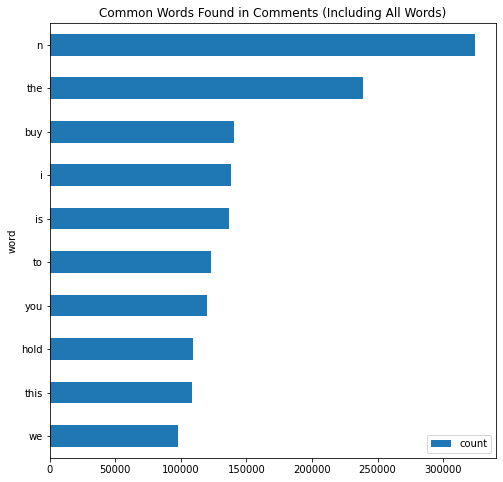

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_body_no_urls.sort_values(by='count', ascending=False).head(10).plot.barh(x='word',
                      y='count',
                      ax=ax,
                      )
ax.invert_yaxis()
ax.set_title("Common Words Found in Comments (Including All Words)")

plt.show()

In [24]:
# remove teh stopwoirds
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\torid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [25]:
stop_words = set(stopwords.words('english'))

# View a few words from the set
list(stop_words)[0:10]

['hasn',
 'can',
 'and',
 'my',
 'doesn',
 'own',
 "didn't",
 "aren't",
 "hadn't",
 'than']

In [26]:
# Remove stop words from each comment list of words
comments_nsw = [[word for word in comment_words if not word in stop_words]
              for comment_words in words_in_comment]

comments_nsw[0]

['amazing']

In [27]:
#count the words withouth the stopwords

all_words_nsw = list(itertools.chain(*comments_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('n', 324329),
 ('buy', 140381),
 ('hold', 109152),
 ('gme', 97099),
 ('amc', 82522),
 ('fuck', 76636),
 ('ban', 75864),
 ('tsla', 72692),
 ('fucking', 66153),
 ('bb', 62907),
 ('go', 59832),
 ('nok', 56116),
 ('penis', 49673),
 ('f', 48603),
 ('calls', 45221)]

In [28]:
counts_nsw.most_common(25)

[('n', 324329),
 ('buy', 140381),
 ('hold', 109152),
 ('gme', 97099),
 ('amc', 82522),
 ('fuck', 76636),
 ('ban', 75864),
 ('tsla', 72692),
 ('fucking', 66153),
 ('bb', 62907),
 ('go', 59832),
 ('nok', 56116),
 ('penis', 49673),
 ('f', 48603),
 ('calls', 45221),
 ('like', 37509),
 ('puts', 35487),
 ('moon', 34127),
 ('spy', 34123),
 ('sell', 34021),
 ('lets', 32076),
 ('stock', 31850),
 ('guh', 30299),
 ('amzn', 30234),
 ('im', 29315)]

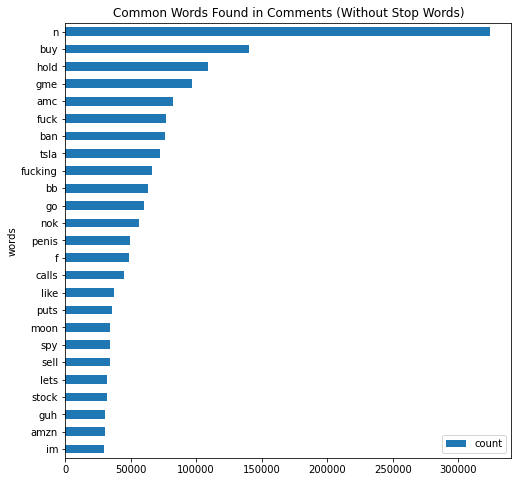

In [29]:
clean_comments_nsw = pd.DataFrame(counts_nsw.most_common(25),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_comments_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax)

ax.set_title("Common Words Found in Comments (Without Stop Words)")

plt.show()

In [30]:
# remove other words from the count

collection_words = ['im', 'dont', 'thats', 'youre']

comments_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in comments_nsw]

In [31]:
# Flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*comments_nsw_nc))

# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)

[('n', 324329),
 ('buy', 140381),
 ('hold', 109152),
 ('gme', 97099),
 ('amc', 82522),
 ('fuck', 76636),
 ('ban', 75864),
 ('tsla', 72692),
 ('fucking', 66153),
 ('bb', 62907),
 ('go', 59832),
 ('nok', 56116),
 ('penis', 49673),
 ('f', 48603),
 ('calls', 45221)]

In [32]:
clean_comments_ncw = pd.DataFrame(counts_nsw_nc.most_common(30),
                             columns=['words', 'count'])
clean_comments_ncw.head()

,words,count
0,n,324329
1,buy,140381
2,hold,109152
3,gme,97099
4,amc,82522


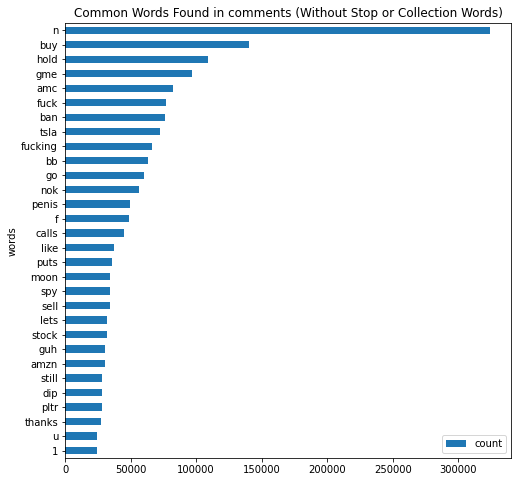

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_comments_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax)

ax.set_title("Common Words Found in comments (Without Stop or Collection Words)")

plt.show()

## Trying Textblob

In [34]:
# Create textblob objects of the comments
# this is very slow to use

sentiment_objects = [TextBlob(comment) for comment in all_comments_no_urls]

sentiment_objects[0].polarity, sentiment_objects[0]

(0.6000000000000001, TextBlob("amazing"))

In [35]:
sentiment_objects[20].polarity, sentiment_objects[20]

(0.0, TextBlob("GUH"))

In [36]:
#function to apply polarity
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

df['polarity'] = df['body_no_urls'].apply(detect_polarity)

df.head(10)

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing,amazing,0.6
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U,u,0.0
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15,isn t ltcg 15,0.0
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH,ahahahahahahhhahh,0.0
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No,no,0.0
5,90,'FinalDevice',2020-01-01 00:19:16,'No. Up ~190%.',3.0,No Up 190,no up 190,0.0
6,109,'CptAlonzoGhostPenis',2020-01-01 00:22:58,"""OP has up's""",4.0,OP has up s,op has up s,0.0
7,111,'Uniqueguy264',2020-01-01 00:23:17,'0*97=0',1.0,0 97 0,0 97 0,0.0
8,117,'patagoniadreaming',2020-01-01 00:24:23,'Fucking how',1.0,Fucking how,fucking how,-0.6
9,118,'IAmNotThatGood',2020-01-01 00:24:36,'No',2.0,No,no,0.0


In [37]:
df.head(20)

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing,amazing,0.6
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U,u,0.0
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15,isn t ltcg 15,0.0
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH,ahahahahahahhhahh,0.0
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No,no,0.0
5,90,'FinalDevice',2020-01-01 00:19:16,'No. Up ~190%.',3.0,No Up 190,no up 190,0.0
6,109,'CptAlonzoGhostPenis',2020-01-01 00:22:58,"""OP has up's""",4.0,OP has up s,op has up s,0.0
7,111,'Uniqueguy264',2020-01-01 00:23:17,'0*97=0',1.0,0 97 0,0 97 0,0.0
8,117,'patagoniadreaming',2020-01-01 00:24:23,'Fucking how',1.0,Fucking how,fucking how,-0.6
9,118,'IAmNotThatGood',2020-01-01 00:24:36,'No',2.0,No,no,0.0


In [38]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(df.loc[df['polarity']<-0.5])

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity
8,117,'patagoniadreaming',2020-01-01 00:24:23,'Fucking how',1.0,Fucking how,fucking how,-0.6
337,5188,'hmkey',2020-01-02 01:31:23,'Fucking statist.',3.0,Fucking statist,fucking statist,-0.6
431,7045,'Howtoshortdow',2020-01-02 06:26:25,'RUTHLESS',2.0,RUTHLESS,ruthless,-1.0
535,8674,'DoctorOzface',2020-01-02 14:01:12,'BORING',2.0,BORING,boring,-1.0
648,9754,'love2fuckbearasshoe',2020-01-02 15:14:24,'TGT GETTING FUCKED buy in now !!',1.0,TGT GETTING FUCKED buy in now,tgt getting fucked buy in now,-0.6
...,...,...,...,...,...,...,...,...
1575494,2177460,'impersonablesnail',2021-06-30 19:54:17,'This is fucking siiiiick',3.0,This is fucking siiiiick,this is fucking siiiiick,-0.6
1575520,2177883,'Calamari_OG',2021-06-30 20:01:57,'NOW I’M RETARDED AND POOR!',3.0,NOW I M RETARDED AND POOR,now i m retarded and poor,-0.6
1575583,2178914,'TigerBlood1910',2021-06-30 20:19:07,'MU FUCKED ME THEN HELD ME IN ITS ARMS I THINK ITS GONNA 🚀🚀🚀🚀🚀🚀',14.0,MU FUCKED ME THEN HELD ME IN ITS ARMS I THINK ITS GONNA,mu fucked me then held me in its arms i think its gonna,-0.6
1575708,2181578,'DayMack8006',2021-06-30 21:22:19,"""NOT AS REKTED AS DIRTY TINA'S PUSSY""",1.0,NOT AS REKTED AS DIRTY TINA S PUSSY,not as rekted as dirty tina s pussy,-0.6


In [39]:
# how to make an average daily score of the sentiment in the forum??



In [40]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(df.loc[df['polarity']>0.8])

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity
1468,22714,'TheCigarKing',2020-01-03 05:08:47,'#GILDED THE BEST DAD 😈🍆',3.0,GILDED THE BEST DAD,gilded the best dad,1.00
1489,22952,'Im_A_Thing',2020-01-03 05:27:36,'LMFAOOOOOO! PERFECT!!!',4.0,LMFAOOOOOO PERFECT,lmfaoooooo perfect,1.00
3289,51791,'sleepyfries',2020-01-06 10:09:54,'CCL LOOKING REAL NICE.',1.0,CCL LOOKING REAL NICE,ccl looking real nice,0.90
4002,61851,'TheLeafyOne2',2020-01-07 01:36:28,"'UPDATE: BEST BUY BUYOUT GUY RESPONDED TO ME, CLAIMS BUYOUT OF HIS COMPANY WAS ANNOUNCED.'",11.0,UPDATE BEST BUY BUYOUT GUY RESPONDED TO ME CLAIMS BUYOUT OF HIS COMPANY WAS ANNOUNCED,update best buy buyout guy responded to me claims buyout of his company was announced,1.00
7704,117418,'[deleted]',2020-01-10 00:49:36,'THIS JUST IN\\~\n\n***DO NOT EVER BET AGAINST THE GREATEST COUNTRY IN THE WORLD***',9.0,THIS JUST IN n n DO NOT EVER BET AGAINST THE GREATEST COUNTRY IN THE WORLD,this just in n n do not ever bet against the greatest country in the world,1.00
...,...,...,...,...,...,...,...,...
1571480,2096400,'thexavier666',2021-06-29 05:15:08,'YOU TURNED MY BEAUTIFUL PRIUS INTO A NIGHTMARE!',5.0,YOU TURNED MY BEAUTIFUL PRIUS INTO A NIGHTMARE,you turned my beautiful prius into a nightmare,0.85
1574548,2156763,'cashflow_',2021-06-30 13:04:33,'EXCELLENT SHITPOSTING BROS. BRAVO',2.0,EXCELLENT SHITPOSTING BROS BRAVO,excellent shitposting bros bravo,1.00
1574561,2156968,'cashflow_',2021-06-30 13:09:03,'I AM THE GREATEST TRADER TO HAVE EVER LIVED',4.0,I AM THE GREATEST TRADER TO HAVE EVER LIVED,i am the greatest trader to have ever lived,1.00
1575578,2178823,'eZtarget247365',2021-06-30 20:17:21,'CTRM or BEST.',1.0,CTRM or BEST,ctrm or best,1.00


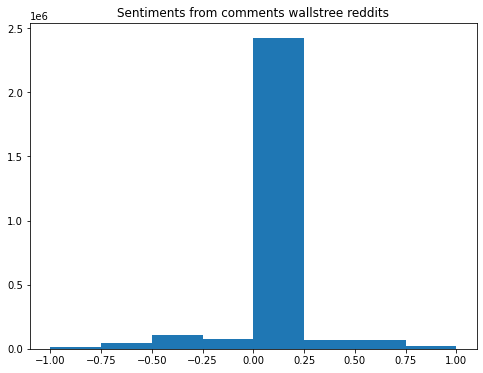

In [41]:
# plot histogram of polarity

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
ax.hist(df['polarity'], bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1])

plt.title("Sentiments from comments wallstree reddits")
plt.show()

In [42]:
# make a daily line polot of commnets
test = pd.DataFrame(df.dtypes)
test.rename(columns = {0:'Data Type'})

# get 

,Data Type
Unnamed: 0,int64
author,object
created_utc,object
body,object
score,float64
body_no_urls,object
words_in_body,object
polarity,float64


In [43]:
#Get the monthly count of posts

volume_posts = df.groupby(pd.Grouper(key='created_utc',freq='D'))['body'].count().to_frame(name = 'count').reset_index()

volume_posts.set_index('created_utc', inplace=True)

volume_posts

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

NameError: name 'volume_posts' is not defined

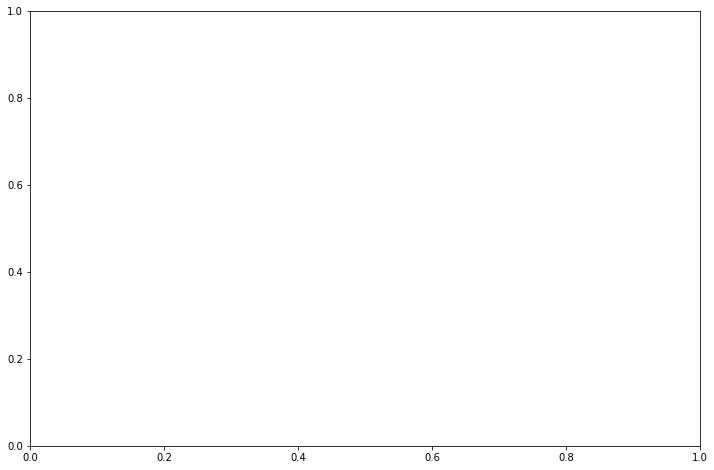

In [44]:
fig, axs = plt.subplots(1,1, figsize=(12,8))

axs.plot( volume_posts['count'], label = "Bernie Sanders", color = 'brown')
axs.set( 
       xlabel='Date', 
       ylabel='Number of posts',
       title='number of daily posts in WallStreetbets 2018-2019')
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [45]:
#Get the average of polarity daily  of posts

daily_polarity_posts = df.groupby(pd.Grouper(key='created_utc',freq='D'))['polarity'].mean().to_frame(name = 'mean_polarity').reset_index()

daily_polarity_posts.set_index('created_utc', inplace=True)

daily_polarity_posts

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

NameError: name 'daily_polarity_posts' is not defined

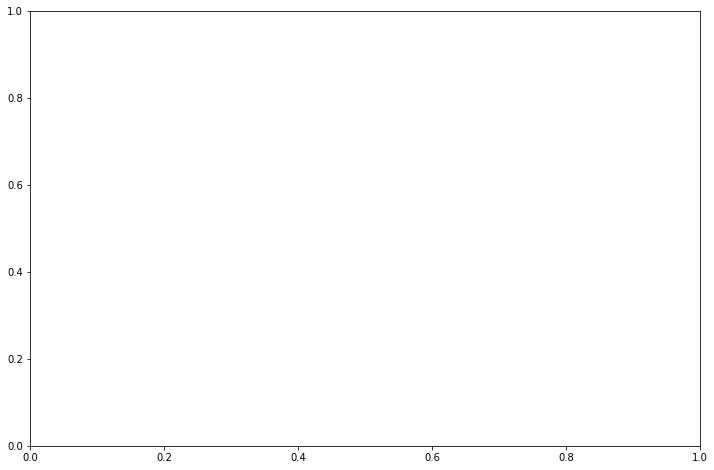

In [46]:
fig, axs = plt.subplots(1,1, figsize=(12,8))

axs.plot( daily_polarity_posts['mean_polarity'], label = "polarity", color = 'brown')
axs.set( ylim=[0,0.2],
       xlabel='Date', 
       ylabel='Average polarity',
       title='Average daily polarity in WallStreetbets 2018-2019')
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [ ]:
#how many negative, neutral and positive comments in a regualr day?


In [47]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\torid\AppData\Roaming\nltk_data...


True

In [48]:
sid = SentimentIntensityAnalyzer()

In [49]:
sid.polarity_scores('i disagree')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3818}

In [50]:
df['vader_score'] = df['body_no_urls'].apply(lambda body_no_urls: sid.polarity_scores(body_no_urls))

df.head()

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing,amazing,0.6,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound..."
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U,u,0.0,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15,isn t ltcg 15,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH,ahahahahahahhhahh,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No,no,0.0,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound..."


In [51]:
#Now will call out compound as a separate column and 
#all values greater than zeroes will be considered a positive comment
#and all values less than zero would be considered as a negative comment


df['vader_compound']  = df['vader_score'].apply(lambda score_dict: score_dict['compound'])

df.head()

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score,vader_compound
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing,amazing,0.6,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.5859
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U,u,0.0,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15,isn t ltcg 15,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH,ahahahahahahhhahh,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No,no,0.0,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",-0.2960


In [52]:
df.head(50)

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score,vader_compound
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing,amazing,0.600000,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.5859
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U,u,0.000000,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15,isn t ltcg 15,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH,ahahahahahahhhahh,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No,no,0.000000,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",-0.2960
5,90,'FinalDevice',2020-01-01 00:19:16,'No. Up ~190%.',3.0,No Up 190,no up 190,0.000000,"{'neg': 0.524, 'neu': 0.476, 'pos': 0.0, 'comp...",-0.2960
6,109,'CptAlonzoGhostPenis',2020-01-01 00:22:58,"""OP has up's""",4.0,OP has up s,op has up s,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
7,111,'Uniqueguy264',2020-01-01 00:23:17,'0*97=0',1.0,0 97 0,0 97 0,0.000000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
8,117,'patagoniadreaming',2020-01-01 00:24:23,'Fucking how',1.0,Fucking how,fucking how,-0.600000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
9,118,'IAmNotThatGood',2020-01-01 00:24:36,'No',2.0,No,no,0.000000,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",-0.2960


In [53]:
#conver to positive or negative

df['vader_category'] = df['vader_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

df.head()

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,polarity,vader_score,vader_compound,vader_category
0,2,'optionseller',2020-01-01 00:00:49,'amazing',2.0,amazing,amazing,0.6,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.5859,pos
1,5,'connnor4real',2020-01-01 00:01:33,'U',10.0,U,u,0.0,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,pos
2,16,'bobloadmire',2020-01-01 00:02:49,"""Isn't LTCG 15%?""",1.0,Isn t LTCG 15,isn t ltcg 15,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
3,53,'grammerknewzi',2020-01-01 00:11:24,'AHAHAHAHAHAHHHAHH',1.0,AHAHAHAHAHAHHHAHH,ahahahahahahhhahh,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
4,78,'Howtoshortdow',2020-01-01 00:16:24,'No',11.0,No,no,0.0,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",-0.2960,neg


In [54]:
# following Ranco proposed formula for sentiment polarity Pd
#Get the average of polarity daily  of posts

daily_vader_polarity_posts = df.groupby(pd.Grouper(key='created_utc',freq='D'))['vader_category'].value_counts().unstack(fill_value=0)

daily_vader_polarity_posts


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [ ]:
daily_vader_polarity_posts['sentiment_vader'] = (daily_vader_polarity_posts['pos']-daily_vader_polarity_posts['neg'])/(daily_vader_polarity_posts['pos']+daily_vader_polarity_posts['neg'])

In [ ]:
daily_vader_polarity_posts

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12,8))

axs.plot( daily_vader_polarity_posts['sentiment_vader'], label = "polarity", color = 'brown')
axs.set( 
       xlabel='Date', 
       ylabel='Polarity',
       title='Daily sentiment polarity in WallStreetbets 2018-2019')
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [ ]:
# get the SP500 tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')


In [ ]:
table[0]

In [ ]:
df3 = df[df['body'].str.contains('YUM', na=False)]

In [ ]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(df3)